In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [109]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [110]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [111]:
mailout_train.shape

(42962, 367)

In [112]:
mailout_test.shape

(42833, 366)

## 1- Clean the data

In [113]:
mailout_train_raw = mailout_train.drop(labels='RESPONSE',axis=1)

In [114]:
mailout_train_raw = mailout_train_raw.sort_values('LNR')
mailout_test_raw = mailout_test.sort_values('LNR')

In [115]:
# Set LNR columns as index
mailout_train_raw = mailout_train_raw.set_index('LNR')
mailout_test_raw = mailout_test_raw.set_index('LNR')

In [116]:
mailout_train_raw['D19_LETZTER_KAUF_BRANCHE'] = mailout_train_raw['D19_LETZTER_KAUF_BRANCHE'].fillna('nan')
mailout_test_raw['D19_LETZTER_KAUF_BRANCHE'] = mailout_test_raw['D19_LETZTER_KAUF_BRANCHE'].fillna('nan')

In [117]:
kf = {'D19_BANKEN_DIREKT':0,
 'D19_BANKEN_GROSS':1,
 'D19_BANKEN_LOKAL':2,
 'D19_BANKEN_REST':3,
 'D19_BEKLEIDUNG_GEH':4,
 'D19_BEKLEIDUNG_REST':5,
 'D19_BILDUNG':6,
 'D19_BIO_OEKO':7,
 'D19_BUCH_CD':8,
 'D19_DIGIT_SERV':9,
 'D19_DROGERIEARTIKEL':10,
 'D19_ENERGIE':11,
 'D19_FREIZEIT':12,
 'D19_GARTEN':13,
 'D19_HANDWERK':14,
 'D19_HAUS_DEKO':15,
 'D19_KINDERARTIKEL':16,
 'D19_KOSMETIK':17,
 'D19_LEBENSMITTEL':18,
 'D19_LOTTO':19,
 'D19_NAHRUNGSERGAENZUNG':20,
 'D19_RATGEBER':21,
 'D19_REISEN':22,
 'D19_SAMMELARTIKEL':23,
 'D19_SCHUHE':24,
 'D19_SONSTIGE':25,
 'D19_TECHNIK':26,
 'D19_TELKO_MOBILE':27,
 'D19_TELKO_REST':28,
 'D19_TIERARTIKEL':29,
 'D19_UNBEKANNT':30,
 'D19_VERSAND_REST':31,
 'D19_VERSICHERUNGEN':32,
 'D19_VOLLSORTIMENT':33,
 'D19_WEIN_FEINKOST':34,
'nan':-1}

##### VII. Creating CAMEO_DEU_2015 dictionary:

In [118]:
print ('The CAMEO_DEU_2015  of customers dataframe are as follows:\n')
set(mailout_train_raw['CAMEO_DEU_2015'])

The CAMEO_DEU_2015  of customers dataframe are as follows:



{'1A',
 '1B',
 '1C',
 '1D',
 '1E',
 '2A',
 '2B',
 '2C',
 '2D',
 '3A',
 '3B',
 '3C',
 '3D',
 '4A',
 '4B',
 '4C',
 '4D',
 '4E',
 '5A',
 '5B',
 '5C',
 '5D',
 '5E',
 '5F',
 '6A',
 '6B',
 '6C',
 '6D',
 '6E',
 '6F',
 '7A',
 '7B',
 '7C',
 '7D',
 '7E',
 '8A',
 '8B',
 '8C',
 '8D',
 '9A',
 '9B',
 '9C',
 '9D',
 '9E',
 'XX',
 nan}

In [119]:
#Replacing NaNs with string NaNs
mailout_train_raw['CAMEO_DEU_2015'] = mailout_train_raw['CAMEO_DEU_2015'].fillna('nan')
mailout_test_raw['CAMEO_DEU_2015'] = mailout_test_raw['CAMEO_DEU_2015'].fillna('nan')

In [120]:
# Defining a dictionary to convert string values to integer
cam = {'1A':1,
 '1B':2,
 '1C':3,
 '1D':4,
 '1E':5,
 '2A':6,
 '2B':7,
 '2C':8,
 '2D':9,
 '3A':10,
 '3B':11,
 '3C':12,
 '3D':13,
 '4A':14,
 '4B':15,
 '4C':16,
 '4D':17,
 '4E':18,
 '5A':19,
 '5B':20,
 '5C':21,
 '5D':22,
 '5E':23,
 '5F':24,
 '6A':25,
 '6B':26,
 '6C':27,
 '6D':28,
 '6E':29,
 '6F':30,
 '7A':31,
 '7B':32,
 '7C':33,
 '7D':34,
 '7E':35,
 '8A':36,
 '8B':37,
 '8C':38,
 '8D':39,
 '9A':40,
 '9B':41,
 '9C':42,
 '9D':43,
 '9E':44,
 'XX':45,
 'nan':-1}

##### VIII. Applying lambda function to each column

In [121]:
def convert_non_values(df,dict,feature):

    df[feature] = df[feature].apply(lambda x: dict[x])

In [122]:
# Converting features discussed previously
convert_non_values(mailout_test_raw,kf,'D19_LETZTER_KAUF_BRANCHE')
convert_non_values(mailout_test_raw,cam,'CAMEO_DEU_2015')
convert_non_values(mailout_train_raw,kf,'D19_LETZTER_KAUF_BRANCHE')
convert_non_values(mailout_train_raw,cam,'CAMEO_DEU_2015')

In [123]:
# Identifying non values columns
mailout_train_raw_subset = mailout_train_raw.select_dtypes(exclude=[np.float, np.int])
mailout_test_raw_subset = mailout_test_raw.select_dtypes(exclude=[np.float, np.int])

In [124]:
mailout_train_raw.to_pickle("mailout_train_raw_subset.pkl")
mailout_test_raw.to_pickle("mailout_test_raw_subset.pkl")

In [125]:
# Dropping columns
clean_mailout_train_raw = mailout_train_raw.drop(['OST_WEST_KZ','EINGEFUEGT_AM'], axis=1)
clean_mailout_test_raw = mailout_test_raw.drop(['OST_WEST_KZ','EINGEFUEGT_AM'], axis=1)

##### II. Converting remaining non values data to numeric values otherwise replace with NaN

In [126]:
clean_mailout_train_raw[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = clean_mailout_train_raw[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric, errors='coerce')
clean_mailout_test_raw[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = clean_mailout_test_raw[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].apply(pd.to_numeric, errors='coerce')

##### III. Replacing unknown (-1) and none (0) values with NaN

In [127]:
clean_mailout_train_raw.replace([0,-1], np.nan, inplace=True)
clean_mailout_test_raw.replace([0,-1], np.nan, inplace=True)

##### IV. Analyzing NaN values in dataset

As we have noticed during the data exploration many of dataset columns contain more than 30% of NaN values. First we go to vizualize the percentage of NaN data in each feature using [Seaborn barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) module. Then according to our analyze we will decide on how many columns to drop.

,Total,Percent
D19_TELKO_ONLINE_QUOTE_12,42922,0.999069
ALTER_KIND4,42921,0.999046
D19_VERSI_ONLINE_QUOTE_12,42902,0.998603
ALTER_KIND3,42788,0.995950
TITEL_KZ,42749,0.995042


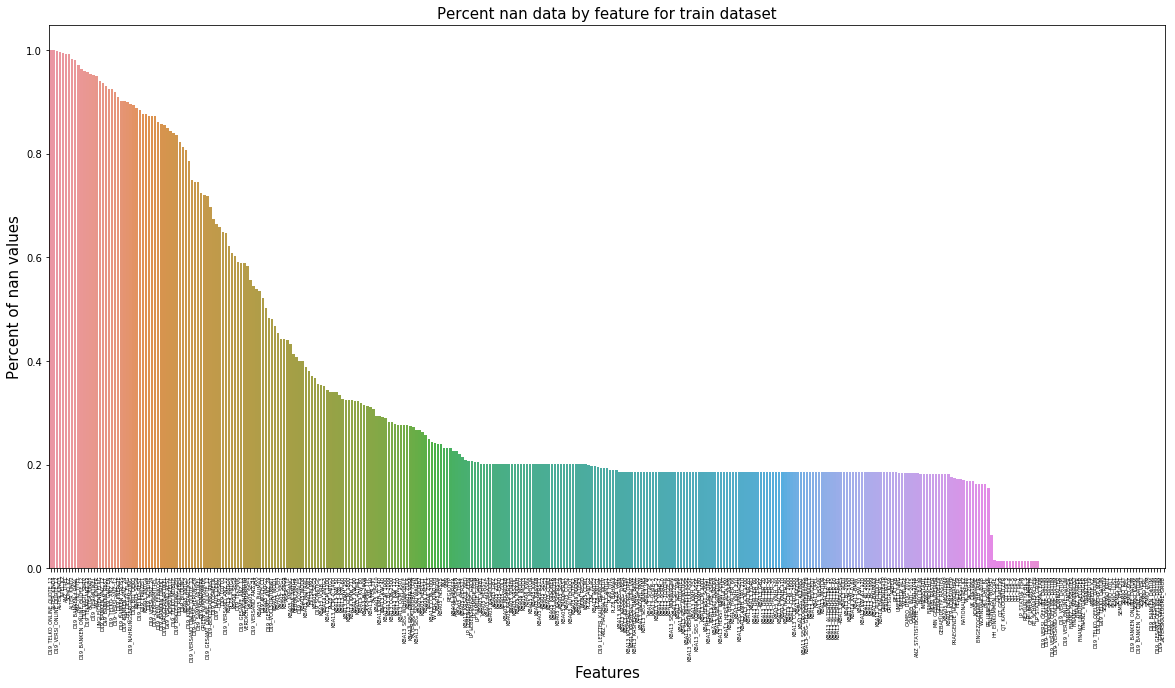

In [128]:
total = clean_mailout_train_raw.isna().sum().sort_values(ascending=False)
percent = (clean_mailout_train_raw.isna().sum()/clean_mailout_train_raw.isna().count()).sort_values(ascending=False)
nan_data_mailout_train_raw = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

f, ax = plt.subplots(figsize=(20, 10))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(5)

    plt.xticks(rotation='90')
sns.barplot(x=nan_data_mailout_train_raw.index, y=nan_data_mailout_train_raw['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of nan values', fontsize=15)
plt.title('Percent nan data by feature for train dataset', fontsize=15)

nan_data_mailout_train_raw.head()

##### V. Dropping columns with more than 10% of NaN values

We have decided to drop columns with more than 20% NaN values in customers dataset and the same operation is applied to azidas dataset in order to get the same output (the same shape for both datasets). First we create a list of features having more han 20% NaNs and then these columns are dropped.

In [129]:
# Dropping same columns in azdias and customers dataset
clean_mailout_train_raw_dropna = clean_mailout_train_raw[['CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
        'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DATUM',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
        'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_TELKO_DATUM',
        'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
        'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'FINANZ_ANLEGER',
        'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP',
        'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'KOMBIALTER', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL',
        'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST',
        'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ',
        'SEMIO_TRADV', 'SEMIO_VERT', 'ZABEOTYP', 'ANREDE_KZ',
        'ALTERSKATEGORIE_GROB']]

In [130]:
clean_mailout_test_raw_dropna = clean_mailout_test_raw[['CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
        'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DATUM',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
        'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_TELKO_DATUM',
        'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
        'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'FINANZ_ANLEGER',
        'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP',
        'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'KOMBIALTER', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL',
        'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SEMIO_KULT', 'SEMIO_LUST',
        'SEMIO_MAT', 'SEMIO_PFLICHT', 'SEMIO_RAT', 'SEMIO_REL', 'SEMIO_SOZ',
        'SEMIO_TRADV', 'SEMIO_VERT', 'ZABEOTYP', 'ANREDE_KZ',
        'ALTERSKATEGORIE_GROB']]

In [131]:
# Remaining features and length 
clean_mailout_train_raw_dropna.columns, len(clean_mailout_train_raw_dropna.columns)

(Index(['CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
        'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DATUM',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
        'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_TELKO_DATUM',
        'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
        'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'FINANZ_ANLEGER',
        'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP',
        'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'KOMBIALTER', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL',
        'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SE

##### VII. Replacing remaining NaNs with -1 value

In [132]:
clean_mailout_train_raw_fillna = clean_mailout_train_raw_dropna.fillna(-1)
clean_mailout_test_raw_fillna = clean_mailout_test_raw_dropna.fillna(-1)

##### VIII. Checking data type and cleaned values

In [133]:
# Counting NaN values for each column
clean_mailout_train_raw_fillna.apply(lambda x:x.isna().sum())
clean_mailout_test_raw_fillna.apply(lambda x:x.isna().sum())

CJT_GESAMTTYP                0
CJT_KATALOGNUTZER            0
CJT_TYP_1                    0
CJT_TYP_2                    0
CJT_TYP_3                    0
CJT_TYP_4                    0
CJT_TYP_5                    0
CJT_TYP_6                    0
D19_BANKEN_DATUM             0
D19_BANKEN_OFFLINE_DATUM     0
D19_BANKEN_ONLINE_DATUM      0
D19_GESAMT_DATUM             0
D19_GESAMT_OFFLINE_DATUM     0
D19_GESAMT_ONLINE_DATUM      0
D19_KONSUMTYP_MAX            0
D19_TELKO_DATUM              0
D19_TELKO_OFFLINE_DATUM      0
D19_TELKO_ONLINE_DATUM       0
D19_VERSAND_DATUM            0
D19_VERSAND_OFFLINE_DATUM    0
D19_VERSAND_ONLINE_DATUM     0
D19_VERSI_DATUM              0
D19_VERSI_OFFLINE_DATUM      0
D19_VERSI_ONLINE_DATUM       0
FINANZ_ANLEGER               0
FINANZ_HAUSBAUER             0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_UNAUFFAELLIGER        0
FINANZ_VORSORGER             0
FINANZTYP                    0
GFK_URLAUBERTYP              0
HH_EINKO

In [134]:
# Data types
set(clean_mailout_train_raw_fillna.dtypes)
set(clean_mailout_test_raw_fillna.dtypes)

{dtype('int64'), dtype('float64')}

##### IX. Normalizing the data

The goal of normalization is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values. In our dataset, normalization is required because features have different ranges. We transforms features by scaling each feature between zero and one using [MinMaxScler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) from Scikitleran module
We create an estimator which scales and translates each feature individually such that it is between zero and one.

In [135]:
# Creating scaled customers dataframe
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

mailout_train_scaled = pd.DataFrame(scaler.fit_transform(clean_mailout_train_raw_fillna.astype(float)))
mailout_train_scaled.index = clean_mailout_train_raw_fillna.index
mailout_train_scaled.columns = clean_mailout_train_raw_fillna.columns

mailout_test_scaled = pd.DataFrame(scaler.fit_transform(clean_mailout_test_raw_fillna.astype(float)))
mailout_test_scaled.index = clean_mailout_test_raw_fillna.index
mailout_test_scaled.columns = clean_mailout_test_raw_fillna.columns

### Save cleaned data as pickle file

In [136]:
mailout_train_scaled.to_pickle("cleaned_mailout_train.pkl")
mailout_train_scaled.to_pickle("cleaned_mailout_test.pkl")

## 2- Dimensionality Reduction with PCA

In [137]:
filename = 'pca_model.sav'
pca_azdias = pickle.load(open(filename, 'rb'))

In [138]:
reduced_mailout_train = pca_azdias.transform(mailout_train_scaled)
reduced_mailout_test = pca_azdias.transform(mailout_test_scaled)

In [139]:
min_features = mailout_train_scaled.shape[1]-1
reduced_mailout_train = pd.DataFrame(data=reduced_mailout_train, \
                                 columns = ['c_{}'.format(i) for i in range(min_features)], \
                                 index = mailout_train_scaled.index)

min_features = mailout_test_scaled.shape[1]-1
reduced_mailout_test = pd.DataFrame(data=reduced_mailout_test, \
                                 columns = ['c_{}'.format(i) for i in range(min_features)], \
                                 index = mailout_test_scaled.index)

In [140]:
reduced_mailout_train.head()

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_46,c_47,c_48,c_49,c_50,c_51,c_52,c_53,c_54,c_55
LNR,,,,,,,,,,,,,,,,,,,,,
1,0.633313,-0.969045,-0.494870,-1.143428,0.731403,0.334638,-0.032156,-0.097593,0.029961,0.037406,...,-0.001572,0.006230,-0.044912,-0.037045,0.001392,0.000314,0.000126,0.000040,-0.000380,0.024426
5,0.602320,-0.515073,-0.789517,-1.173841,0.843082,0.350187,-0.202789,-0.055925,0.205694,-0.184959,...,-0.006888,0.014425,-0.187576,-0.027908,-0.000760,0.001553,0.002093,0.000328,-0.000828,0.027867
9,0.633313,-0.969045,-0.494870,-1.143428,0.731403,0.334638,-0.032156,-0.097593,0.029961,0.037406,...,-0.001572,0.006230,-0.044912,-0.037045,0.001392,0.000314,0.000126,0.000040,-0.000380,0.024426
10,0.633313,-0.969045,-0.494870,-1.143428,0.731403,0.334638,-0.032156,-0.097593,0.029961,0.037406,...,-0.001572,0.006230,-0.044912,-0.037045,0.001392,0.000314,0.000126,0.000040,-0.000380,0.024426
11,-0.455526,-0.452935,1.060285,-0.600518,0.012174,-0.524961,0.022830,0.061882,-0.066046,-0.010786,...,0.053181,-0.282793,0.028975,-0.034087,-0.374502,0.057363,0.014396,0.002156,0.009773,-0.024367


In [141]:
# The good top_n for azdias dataframe
top_n=16
print ('We retain {} components and capture {}% explained variance for train dataframe'\
       .format(top_n,(pca_azdias.explained_variance_ratio_[:top_n].sum()*100).round(2)))
print ('We retain {} components and capture {}% explained variance for test dataframe'\
       .format(top_n,(pca_azdias.explained_variance_ratio_[:top_n].sum()*100).round(2)))

We retain 16 components and capture 84.21% explained variance for train dataframe
We retain 16 components and capture 84.21% explained variance for test dataframe


In [142]:
columns = ['c_{}'.format(i) for i in range(top_n)]
reduced_mailout_train = reduced_mailout_train[columns]
reduced_mailout_test = reduced_mailout_test[columns]

In [143]:
reduced_mailout_train.shape

(42962, 16)

In [144]:
reduced_mailout_train.to_pickle("reduced_mailout_train.pkl")
reduced_mailout_test.to_pickle("reduced_mailout_test.pkl")

## 3- K-means Clustering

## 4- Benchmark Model

In [2]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
mailout_train_raw2 = mailout_train.sort_values('LNR')
mailout_test_raw2 = mailout_test.sort_values('LNR')

In [5]:
# Set LNR columns as index
mailout_train_raw2 = mailout_train_raw2.set_index('LNR')
mailout_test_raw2 = mailout_test_raw2.set_index('LNR')

In [6]:
reduced_mailout_train = pd.read_pickle('reduced_mailout_train.pkl')
reduced_mailout_test = pd.read_pickle('reduced_mailout_test.pkl')

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [8]:
X = reduced_mailout_train
y = mailout_train_raw2['RESPONSE']

To understand model performance, dividing the dataset into a training set and a test set is a good strategy.
Let's split dataset by using function **train_test_split()**. You need to pass 3 parameters features, target, and test_set size. Additionally, you can use random_state to select records randomly.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.33, random_state=42)

Here, the Dataset is broken into two parts in a ratio of 67:33. It means 67% data will be used for model training and 33% for model testing.

##### Model Development and Prediction

First, import the Logistic Regression module and create a Logistic Regression classifier object using LogisticRegression() function.

Then, fit your model on the train set using fit() and perform prediction on the test set using predict().

In [10]:
ln = LogisticRegression()

In [11]:
model = ln.fit(X_train, y_train)

In [12]:
ln

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Predicting the test set results and calculating the accuracy

In [13]:
y_pred = ln.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(ln.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


##### Confusion Matrix

In [ ]:
# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

Here, you can see the confusion matrix in the form of the array object. The dimension of this matrix is 2*2 because this model is binary classification. You have two classes 0 and 1. Diagonal values represent accurate predictions, while non-diagonal elements are inaccurate predictions. In the output, 119 and 36 are actual predictions, and 26 and 11 are incorrect predictions.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.